<p style="text-align:center;"> <span style="color:green; font-weight:bold; font-size:24px;"> Pre-Processing Algorithms in ML Fairness: Disparate Impact Remover </span> </p>

**Introduction**

In the realm of machine learning, ensuring fairness is a paramount concern to avoid discrimination and bias in model predictions. This post aims to provide an insightful guide on utilizing the Disparate Impact Remover (DIR) method, a powerful preprocessing technique from IBM AIF360 toolkit, to address and mitigate disparities in machine learning models.

**Pre-processing algorithms**

One effective approach to achieve fairness is through preprocessing techniques. These methods modify the training data before model training, rectifying any underlying biases present in the dataset. By tackling biases at the data level, we lay a solid foundation for equitable model predictions. 

**Disparate Impact Remover**

The Disparate Impact Remover (DIR) is a preprocessing technique provided by AIF360 toolkit. Its primary goal is to mitigate disparate impact, which occurs when different groups are treated unfairly by a model's predictions. DIR works by adjusting the dataset to ensure similar prediction distributions across different sensitive attribute groups.

In plain English, the disparate impact ratio is the ratio of positive outcomes (for example, Loan_Status=1 or Loan_default=0) in the unprivileged group divided by the ratio of positive outcomes in the privileged group. The AIF360 tool suggests that an acceptable lower bound is 80%. That is, if the unprivileged group receives a positive outcome less than 80% of the time that the privileged group does, it is a disparate impact violation.

**Problem Statement**

We use a credit loan decision dataset to evaluate the disparity between genders before and after applying the DIR: 
* First, we evaluate the disparity between the positive outcomes in different genders in the original dataset.
* Then, we tranform the dataset using the DIR method.
* Next, we train a LightGBM model using the transformed dataset and predict the test datset
* Finally, we compare the outcomes of the ML model with the original dataset.

## **1. Install Required Packages - Import Libraries**

In [ ]:
pip install aif360

In [ ]:
pip install xlrd

In [ ]:
pip install BlackBoxAuditing

In [3]:
import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

import lightgbm as lgb

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from aif360.algorithms.preprocessing import DisparateImpactRemover
from aif360.datasets import BinaryLabelDataset, Dataset
from aif360.metrics import BinaryLabelDatasetMetric

rand_seed = 1234
np.random.seed(rand_seed)

## **2. Dataset**

The dataset we'll use for this tutorial is the credit loan decision used in the Ernst & Young case study published on Microsoft Fairlearn. By utilizing DIR, we'll showcase how to reduce disparities in the dataset and align model predictions with fairness goals.
 
To download the dataset or to use it in your analysis, you can refer to [this link](https://www.kaggle.com/datasets/mohammadbolandraftar/credit-card-defaults-in-taiwan-ml-fairness), and for more information about the case study, please refer to [Fairlearn page](https://fairlearn.org/main/auto_examples/plot_credit_loan_decisions.html).

**Note:** To work with the DIR, we need to define the privileged/unprivileged groups and favorable/unfavorable outcomes. In our case, default=1 is unfavorable and default=0 is favorable. We also assume that female applicants are the unprivileged group.

In [4]:
data_url = "/kaggle/input/credit-card-defaults-in-taiwan-ml-fairness/default of credit card clients (1).xls"
dataset = pd.read_excel(data_url, header=1).drop(columns=["ID"]).rename(columns={"PAY_0": "PAY_1", "default payment next month": "default"})

print("size of dataset:", dataset.shape)
print()
dataset.head()

size of dataset: (30000, 24)



,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


### **2.1. Evaluate Disparity Between Genders**

There are two ways to evaluate disparities:

1. Calculating the disparity proportion through Python coding
2. We can also use the AIF360 metrics to calculate the disparity ratio

I've provided the both methods in the following cells.

**2.1.1. Calculate Manually**

In [5]:
def calc_prop(data, group_col, group, output_col, output_val):
    new = data[data[group_col] == group]
    return len(new[new[output_col] == output_val])/len(new)

parity_rate_male = calc_prop(dataset, "SEX", 1, "default", 0)
parity_rate_female = calc_prop(dataset, "SEX", 2, "default", 0)
print("parity_rate_male:", parity_rate_male)
print("parity_rate_female:", parity_rate_female)
print("parity rate ration female/male:", parity_rate_female/parity_rate_male)

parity_rate_male: 0.7583277254374159
parity_rate_female: 0.7922371908127208
parity rate ration female/male: 1.0447161091937465


**2.1.2. Use AIF360 Metrics**

First, we need the define privileged and unprivileged groups

In [6]:
privileged_group = [{'SEX': 1}]
unprivileged_group = [{'SEX': 2}]

Now, we need to convert DataFrame to BinaryLabelDataset:

In [7]:
binary_label_dataset_original = BinaryLabelDataset(df=dataset, 
                                        label_names=['default'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )

At this stage, we can calculate the Disparate Impact:

In [8]:
di = BinaryLabelDatasetMetric(binary_label_dataset_original,
                              unprivileged_groups = unprivileged_group,
                              privileged_groups = privileged_group
                             ).disparate_impact()

print("Disparate Impact:", di)

Disparate Impact: 1.0447161091937465


### **2.2. Change Dataset Distribution**

As we see, there is not a large disparity between the positive outcomes in male and female applicants. So, **for educational purposes**, we change the distribution of positive outcomes in females such that they receive less positive outcome. This helps us define them as our unprivileged group. The following code changes 40% of default values from 0 to 1 in females applicants.

In [9]:
df = dataset.copy()

# filters the non-default females
mask = (df['SEX'] == 2) & (df['default'] == 0)

# picks 40% of the filtered rows randomly 
rows_to_change = df[mask].sample(frac=0.4, random_state=42)

# Change the default values to 1 for the selected rows
df.loc[rows_to_change.index, 'default'] = 1

In [10]:
model_features = [col for col in df.columns if col not in ["default"]]
model_target = ["default"]

### **2.3. Evaluate DIR After Changing Dataset Distribution**

let's evaluate the disparity impact after changing the dataset distribution

In [11]:
binary_label_dataset_new = BinaryLabelDataset(df=df, # from now on, we'll work on the df
                                              label_names=['default'], 
                                              protected_attribute_names=['SEX'],
                                              favorable_label=0, # non-default
                                              unfavorable_label=1, # default label
                                              )

# Calculate disparate impact in the new dataset
di_new= BinaryLabelDatasetMetric(binary_label_dataset_new,
                                 unprivileged_groups = unprivileged_group,
                                 privileged_groups = privileged_group
                                ).disparate_impact()

print("Disparate Impact in the new dataset:", di_new)

Disparate Impact in the new dataset: 0.62680054248024


The code worked. Now, the disparity ratio is around 63% which is far lower than 80% for the lower band of parity.

## **3. Transform Dataset by Applying Disparate Impact Remover**

In the first step, we need to apply the DIR and transform the dataset. Then, we use the "convert_to_dataframe" method to create a dataframe of the transformed dataset. 
The DIR algorithm requires the user to specify a repair_level, this indicates how much you wish for the distributions of the groups to overlap. Repair_level takes values between 0.0 and 1.0. Repair amount 0.0 means no repair while 1.0 is full repair.

In [12]:
def apply_dir(rep_lev, bin_label_data):
    di_remover = DisparateImpactRemover(repair_level=rep_lev)
    binary_label_dataset_transformed = di_remover.fit_transform(bin_label_data)
    df_transformed = binary_label_dataset_transformed.convert_to_dataframe()[0] # create the transformed dataframe
    return df_transformed

In this step, I'm applying DIR on the "df" to show you how the dataset is transformed. The name of the transformed dataset is "transformed_df". I'm using the repair_level of 0.9. 

In [13]:
# Convert DataFrame to BinaryLabelDataset
binary_label_dataset = BinaryLabelDataset(df=df, # Our goal is to transform the df dataset
                                        label_names=['default'], 
                                        protected_attribute_names=['SEX'],
                                        favorable_label=0, # non-default
                                        unfavorable_label=1, # default label
                                        )

df_transformed = apply_dir(0.9, binary_label_dataset) # repair_level=0.9

After applying the DisparateImpactRemover, we have transformed the df to df_transformed. Let's check the results:

In [14]:
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,1
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [15]:
df_transformed.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000.0,2.0,2.0,1.0,24.0,2.0,2.0,-1.0,-1.0,-2.0,...,-57.0,-50.0,-96.0,0.0,689.0,0.0,0.0,0.0,0.0,1.0
1,120000.0,2.0,2.0,2.0,26.0,-1.0,2.0,0.0,0.0,0.0,...,3272.0,3452.0,3261.0,0.0,1000.0,835.0,831.0,0.0,1768.0,1.0
2,90000.0,2.0,2.0,2.0,34.0,0.0,0.0,0.0,0.0,0.0,...,14331.0,14948.0,15549.0,1467.0,1450.0,835.0,831.0,866.0,4382.0,1.0
3,50000.0,2.0,2.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,27121.0,27692.0,28590.0,1853.0,1905.0,1036.0,921.0,936.0,841.0,0.0
4,50000.0,1.0,2.0,1.0,57.0,-1.0,0.0,-1.0,0.0,0.0,...,20940.0,19146.0,19131.0,2000.0,32520.0,10000.0,9000.0,689.0,679.0,0.0


As you can see, some elements, e.g. rows 2 and 3 in the PAY_AMT1 have changed.

**Visualize the distribution of data in "BILL_AMT6" before and after applying DIR**

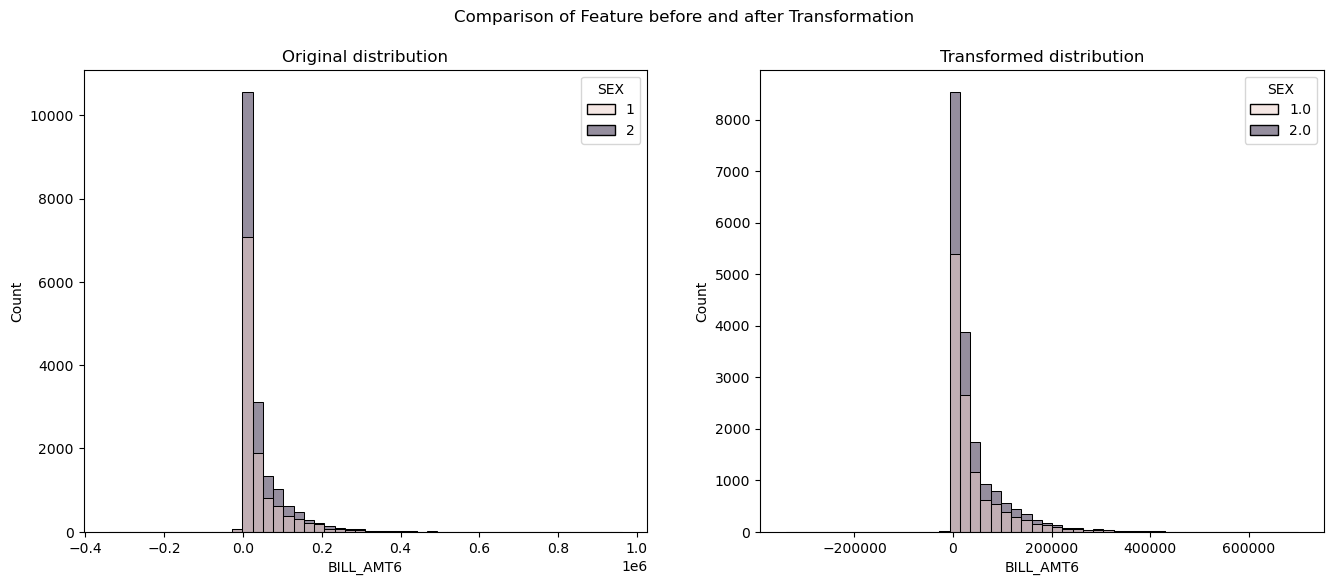

In [16]:
%matplotlib inline

# Initialize figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Set title of figure
fig.suptitle("Comparison of Feature before and after Transformation")

# Set title
ax1.title.set_text("Original distribution")
ax2.title.set_text("Transformed distribution")

# Create plots
sns.histplot(df, x="BILL_AMT6", hue="SEX", bins=50, ax=ax1)
sns.histplot(df_transformed, x="BILL_AMT6", hue="SEX", bins=50, ax=ax2)
plt.show()

<span style="color:red"> **Important Note:** By calculating the disparity impact in the transformed dataset, you'll notice that it's equal to the original dataset. This is due to the fact that you changed the distribution of data in dataset features except in the protected feature ("SEX" in our case) and target feature ("default"). So, there will be no change in the Disparity Impact. Let's check it together:</span> 

In [17]:
parity_rate_male = calc_prop(df_transformed, "SEX", 1, "default", 0)
parity_rate_female = calc_prop(df_transformed, "SEX", 2, "default", 0)
print("parity_rate_male:", parity_rate_male)
print("parity_rate_female:", parity_rate_female)
print("parity rate ration female/male:", parity_rate_female/parity_rate_male)

parity_rate_male: 0.7583277254374159
parity_rate_female: 0.4753202296819788
parity rate ration female/male: 0.62680054248024


As we see, the disparity rate hasn't changed.

## **4. Create Train & Test Datasets**

In [18]:
def tr_test_splt(df_tr, features, target, df):
    train_df_transformed, test_df_transformed = train_test_split(df_tr, 
                                                                 test_size=0.3, 
                                                                 random_state=42, 
                                                                 shuffle=True)
    
    train_df, test_df = train_test_split(df, 
                                         test_size=0.3, 
                                         random_state=42, 
                                         shuffle=True)

    x_train_transformed = train_df_transformed[features]
    y_train_transformed = train_df_transformed[target]

    x_test_transformed = test_df_transformed[features]
    y_test_transformed = test_df_transformed[target]
    
    return test_df, train_df_transformed, test_df_transformed, x_train_transformed, y_train_transformed, x_test_transformed, y_test_transformed

## **5. Create the ML model**

In [19]:
def lgb_model(x_train_transformed, y_train_transformed, x_test_transformed):
    # Initialize LightGBM model
    lgb_params = {
        "objective": "binary",
        "metric": "auc",
        "learning_rate": 0.03,
        "num_leaves": 10,
        "max_depth": 3,
        "random_state": rand_seed,
        "n_jobs": 1,
    }

    lgb_dir = Pipeline(
        steps=[
            ("preprocessing", StandardScaler()),
            ("classifier", lgb.LGBMClassifier(**lgb_params)), 
              ]
                        )

    lgb_dir.fit(x_train_transformed, y_train_transformed.values.ravel())

    y_pred_test_lgb_dir = lgb_dir.predict(x_test_transformed)
    
    return y_pred_test_lgb_dir

## **6. Build DataFrame for Evaluation purposes**

In this section we evaluate the Disparity Impact before and after applying the LightGBM model. To do this, we create a dataframe with the following features: "SEX" & "default" in the transformed test dataset (before appying the ML model), and the model prediction.

In [20]:
def get_results(test_df_transformed, y_pred_test_lgb_dir):
    all_results = pd.concat(
        [
            test_df_transformed.reset_index(drop=True)[["SEX", "default"]],
            pd.Series(y_pred_test_lgb_dir, name="y_pred_test_lgb_dir"),  
        ],
        axis=1
    )
    return all_results

We create a function to compare the Disparity Impact in the transformed dataset and the model prediction.

In [21]:
def gen_dir_results(test_df, all_results):

    # Convert test_df DataFrame to BinaryLabelDatase
    binary_label_dataset_original_test = BinaryLabelDataset(df=test_df, 
                                                            label_names=['default'], 
                                                            protected_attribute_names=['SEX'],
                                                            favorable_label=0, 
                                                            unfavorable_label=1, 
                                                            )

    # Calculate disparate impact in the original test dataset, before applying DIR
    dir_metrics_original_test = BinaryLabelDatasetMetric(binary_label_dataset_original_test,
                                                        unprivileged_groups = unprivileged_group,
                                                        privileged_groups = privileged_group
                                                        ).disparate_impact()

    print("Disparate Impact in _original_test:", dir_metrics_original_test)

    # Convert y_pred_test_lgb_dir (the model prediction) DataFrame to BinaryLabelDataset
    binary_label_dataset_lgb_dir = BinaryLabelDataset(df=all_results, 
                                                      label_names=['y_pred_test_lgb_dir'], 
                                                      protected_attribute_names=['SEX'],
                                                      favorable_label=0, 
                                                      unfavorable_label=1, 
                                                      )

    # Calculate disparate impact in the predicted dataset generated by the LightGBM
    dir_metrics_lgb_dir = BinaryLabelDatasetMetric(binary_label_dataset_lgb_dir,
                                                   unprivileged_groups = unprivileged_group,
                                                   privileged_groups = privileged_group
                                                   ).disparate_impact()

    print("Disparate Impact in lgb_dir:", dir_metrics_lgb_dir)

## **7. Compare Results**

In this section, we compare the results before and after applying the LightGBM model. We can change the code such that it transforms the original dataset with different repair levels.

In [22]:
for i in range(1, 11):
    repair_level = i / 10 
    print("repair_level:", repair_level)
    df_transformed = apply_dir(repair_level, binary_label_dataset)
    test_df, train_df_transformed, test_df_transformed, x_train_transformed, y_train_transformed, x_test_transformed, y_test_transformed = tr_test_splt(df_transformed, model_features, model_target, df)
    y_pred_test_lgb_dir = lgb_model(x_train_transformed, y_train_transformed, x_test_transformed)
    all_results = get_results(test_df_transformed, y_pred_test_lgb_dir)
    gen_dir_results(test_df, all_results)
    print()

repair_level: 0.1
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7447477568599761

repair_level: 0.2
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7412007060084465

repair_level: 0.3
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7496570745881207

repair_level: 0.4
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7445364809005831

repair_level: 0.5
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.753436247567103

repair_level: 0.6
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7449357357230566

repair_level: 0.7
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7451475457133105

repair_level: 0.8
Disparate Impact in _original_test: 0.6304030238662313
Disparate Impact in lgb_dir: 0.7413798323741874

repair_level: 0.9
Dispara

As we can see, the model prediction has a higher disparity impact for different repair_level values although it's still below the 80% disparity.

## **8. Conclusion**

In this example we applied the DIR method to mitigate the disparity between the female and male applicants. We transformed the dataset and then applied LightGBM model. The LightGBM model results using the transformed dataset shows a lower disparity between females and males.

**Considerations**

* As data scientists, it's crucial to acknowledge that the Disparate Impact Remover stands as a viable pre-processing tool to rectify dataset disparities. However, its applicability isn't universal across all datasets. To gauge its effectiveness, a prudent approach involves assessing the original dataset's disparity, followed by comparison with a fairness-unaware model (e.g. applying the LightGBM model on the original dataset in our case) and fairness-aware (applying the LightGBM model on the transformed dataset in this example). Only through this comparison can we ascertain the extent of its effectiveness in transforming the dataset's dynamics.
* This method may not be applicable on all datasets and that's why we have other pre-processing techniques in fairness libraries.
* If the pre-processing techniques don't work, we need to test the in-processing or post-processing methods.